In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import regex as re
import nltk
from tqdm import tqdm
import os
tqdm.pandas()

nltk.download('stopwords')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ismae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
ps = PorterStemmer()

stop_words = set(stopwords.words('english'))

# Reduce each word to its root and remove common words without meaning
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower().split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stop_words]
    return ' '.join(stemmed_content)

cache_file = 'procossed_data.csv'
force_refresh = False

# just load cached data
if os.path.exists(cache_file) and not force_refresh:
    print('Loading processed data...')
    data = pd.read_csv(cache_file)
# otherwise process data
else:
    trueData = pd.read_csv('datasets/gossipcop_real.csv')
    falseData = pd.read_csv('datasets/gossipcop_fake.csv')
    trueData['label'] = 1
    falseData['label'] = 0
    data = pd.concat([trueData,falseData], ignore_index=True)
    data = data.fillna(' ')
    data['content'] = data['title'] + data['text']
    data['content'] = data['content'].progress_apply(stemming)
    data.to_csv(cache_file, index=False)

data['content'] = data['content'].fillna(' ')
data['content'] = data['content'].astype(str)

100%|█████████████████████████████████████████████████████████████████████████████| 7463/7463 [00:52<00:00, 143.24it/s]


In [3]:
x = data['content'].values
y = data['label'].values
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state=142857)

# convert text data into numerical values for the model
vectorizer = TfidfVectorizer()
xTrainVectorized = vectorizer.fit_transform(xTrain)
xTestVectorized = vectorizer.transform(xTest)

axes = ['Fake News', 'Real News']

def test_model(name, model):
    model.fit(xTrainVectorized, yTrain)
    yPred = model.predict(xTestVectorized)
    print(f'{name} metrics:')
    print("Accuracy:", accuracy_score(yTest, yPred))
    print(classification_report(yTest, yPred))
    cm = confusion_matrix(yTest, yPred, labels=[0, 1])
    train_sizes, train_scores, test_scores = learning_curve(model, xTrainVectorized, yTrain, cv=5)
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=axes)
    cm_display.plot(cmap=plt.cm.Blues)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    print("\n")
    
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Testing Score')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy Score')
    plt.title(f'Learning Curve for {name}')
    plt.legend()
    plt.show()

    predict_fake_news('NASA just landed the first humans on Mars',model,vectorizer)
    predict_fake_news('The sky is blue',model,vectorizer)

# test fake news detection with the model
def predict_fake_news(text, model, vectorizer):
    # Preprocess the input
    content = re.sub('[^a-zA-Z]', ' ', text)
    content = content.lower().split()
    content = [ps.stem(word) for word in content if word not in stop_words]
    content = ' '.join(content)
    
    # Transform using the same vectorizer
    vectorized_text = vectorizer.transform([content])
    
    # Predict
    prediction = model.predict(vectorized_text)[0]
    result = "Real News" if prediction == 1 else "Fake News"
    print(f'{text} is {result}')

Logistic Regression metrics:
Accuracy: 0.8030810448760884
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1000
           1       0.73      0.64      0.68       493

    accuracy                           0.80      1493
   macro avg       0.78      0.76      0.77      1493
weighted avg       0.80      0.80      0.80      1493



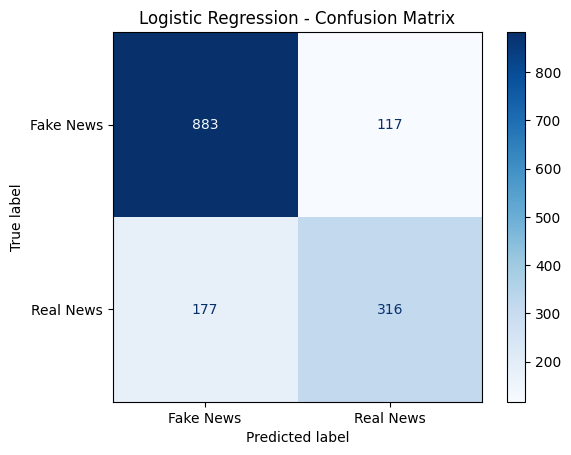

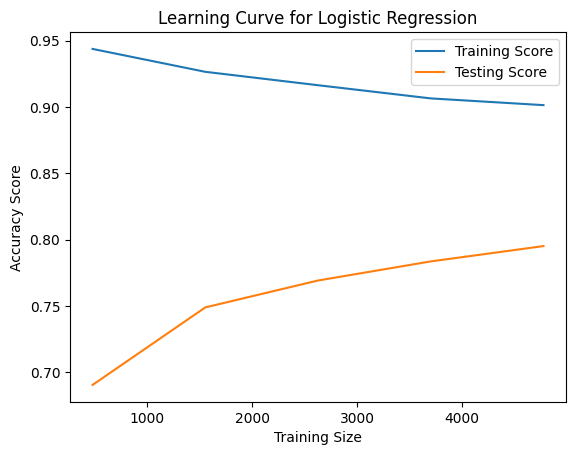

NASA just landed the first humans on Mars is Fake News
The sky is blue is Real News
Support Vector Machine metrics:
Accuracy: 0.8017414601473544
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      1000
           1       0.71      0.68      0.69       493

    accuracy                           0.80      1493
   macro avg       0.78      0.77      0.77      1493
weighted avg       0.80      0.80      0.80      1493



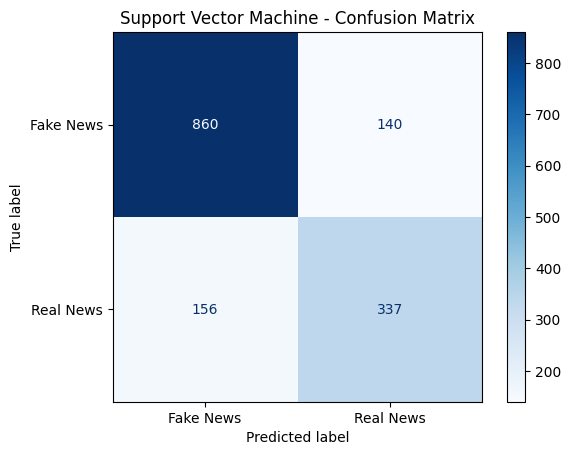

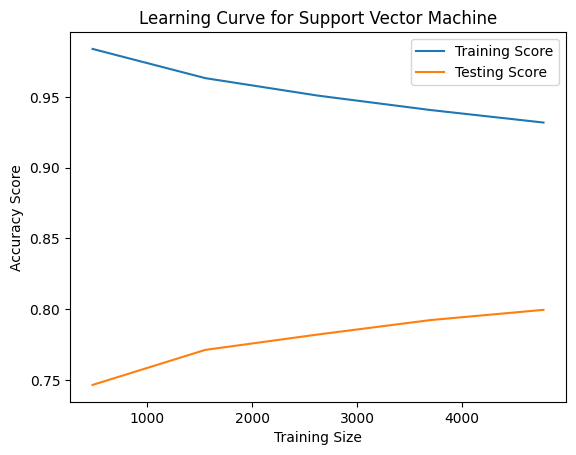

NASA just landed the first humans on Mars is Fake News
The sky is blue is Real News
Naive Bayes metrics:
Accuracy: 0.6791694574681849
              precision    recall  f1-score   support

           0       0.68      0.99      0.81      1000
           1       0.79      0.04      0.07       493

    accuracy                           0.68      1493
   macro avg       0.73      0.52      0.44      1493
weighted avg       0.72      0.68      0.56      1493



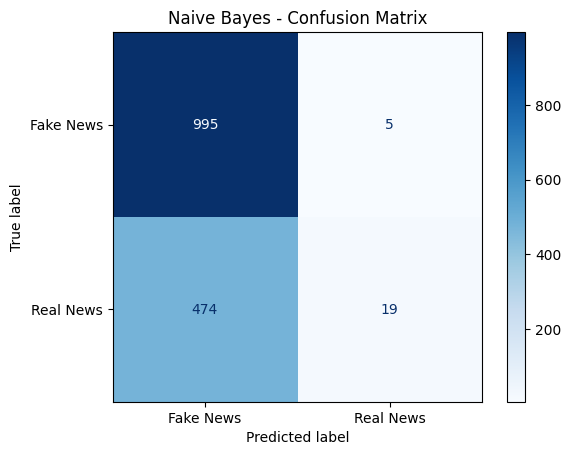

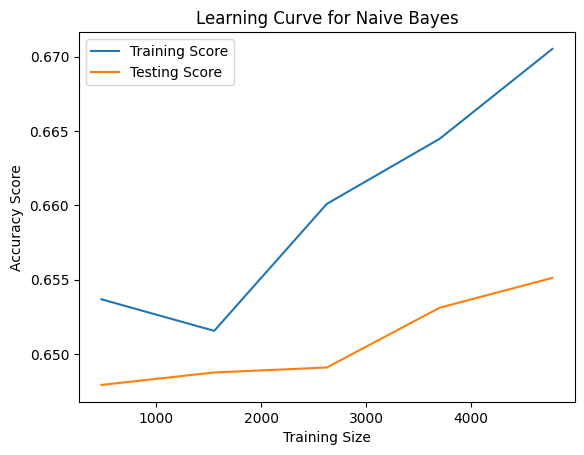

NASA just landed the first humans on Mars is Fake News
The sky is blue is Fake News


In [4]:
logisticModel = LogisticRegression(max_iter=1000)
test_model('Logistic Regression',logisticModel)

svm = SVC(kernel='linear')
test_model('Support Vector Machine',svm)

nb = MultinomialNB()
test_model('Naive Bayes',nb)
